In [1]:
from pandas import read_csv, DataFrame, Grouper, Series
from sklearn.metrics import mean_squared_error
from math import sqrt, log, exp
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import warnings
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
import numpy

series_org = read_csv('monthly-robberies.csv', header=0, 
             index_col=0, parse_dates=True).squeeze("columns")
split_point = len(series_org) - 12
#print(split_point)
dataset, validation = series_org[0:split_point], series_org[split_point:]
#print(dataset, validation)
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


In [3]:
# evaluate a persistence model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, 
         parse_dates=True).squeeze("columns")
print(series)
# prepare data
X = series.values
#print(X)
X = X.astype('float32')
#print(X)
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

0
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1974-06-01    287
1974-07-01    355
1974-08-01    460
1974-09-01    364
1974-10-01    487
Name: 1, Length: 106, dtype: int64
>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expect

In [3]:
# summary statistics of time series
print(series.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


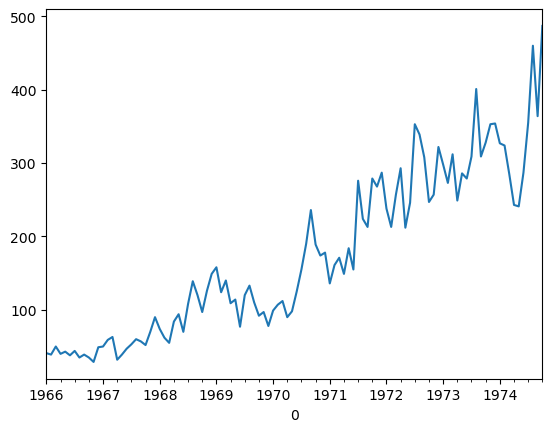

In [4]:
series.plot()
pyplot.show()

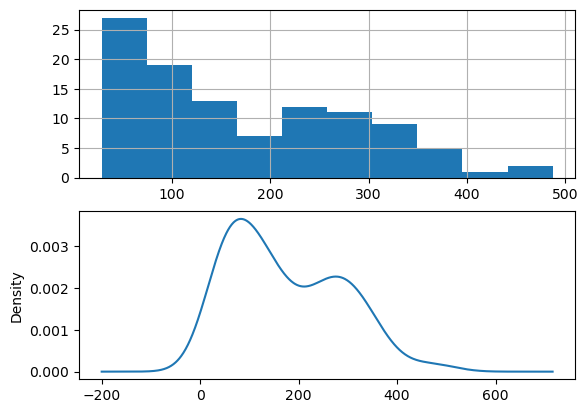

In [5]:
# density plots of time series
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

    1966  1967  1968  1969  1970  1971  1972  1973
0     41    50    74   158    99   136   238   298
1     39    59    62   124   107   161   213   273
2     50    63    55   140   112   171   257   312
3     40    32    84   109    90   149   293   249
4     43    39    94   114    98   184   212   286
5     38    47    70    77   125   155   246   279
6     44    53   108   120   155   276   353   309
7     35    60   139   133   190   224   339   401
8     39    57   120   110   236   213   308   309
9     35    52    97    92   189   279   247   328
10    29    70   126    97   174   268   257   353
11    49    90   149    78   178   287   322   354


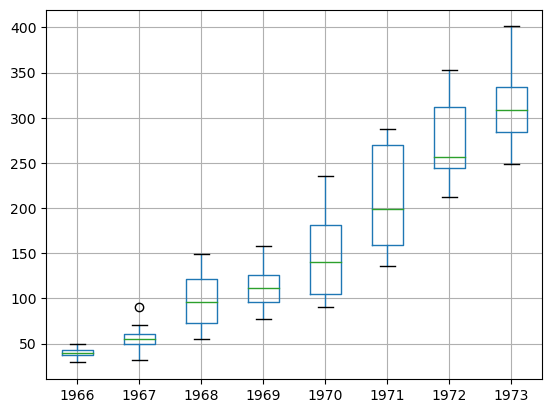

In [6]:
groups = series['1966':'1973'].groupby(Grouper(freq='A'))
#print(groups)
years = DataFrame()
#print(years)
for name, group in groups:
    years[name.year] = group.values
print(years)
years.boxplot()
pyplot.show()

In [7]:
print(years.describe())

            1966       1967        1968        1969        1970        1971  \
count  12.000000  12.000000   12.000000   12.000000   12.000000   12.000000   
mean   40.166667  56.000000   98.166667  112.666667  146.083333  208.583333   
std     5.905827  14.875239   30.700410   24.432963   47.233383   56.737767   
min    29.000000  32.000000   55.000000   77.000000   90.000000  136.000000   
25%    37.250000  49.250000   73.000000   95.750000  105.000000  159.500000   
50%    39.500000  55.000000   95.500000  112.000000  140.000000  198.500000   
75%    43.250000  60.750000  121.500000  126.250000  180.750000  270.000000   
max    50.000000  90.000000  149.000000  158.000000  236.000000  287.000000   

             1972        1973  
count   12.000000   12.000000  
mean   273.750000  312.583333  
std     47.899753   41.655423  
min    212.000000  249.000000  
25%    244.000000  284.250000  
50%    257.000000  309.000000  
75%    311.500000  334.250000  
max    353.000000  401.000000  


ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


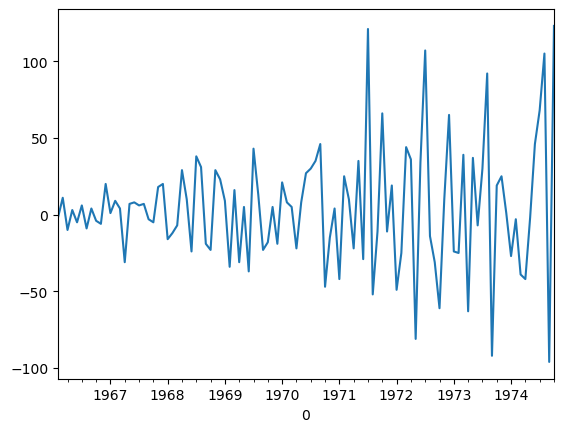

In [19]:
# statistical test for the stationarity of the time series

# create a difference
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

#print(series)
# difference data
stationary = difference(X)
#print(stationary)
stationary.index = series.index[1:]
#print(series.index[1:])
#print(stationary)
# check if stationary
result = adfuller(stationary)
#print(result)
# print(len(result))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv', header=False)

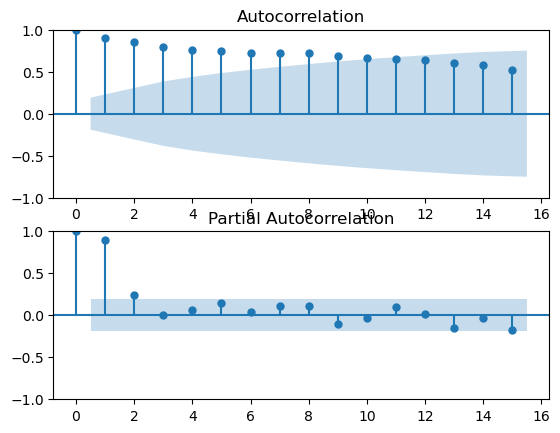

In [9]:
# ACF and PACF plots of time series
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=15, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=15, ax=pyplot.gca(), method='ywm')
pyplot.show()

In [14]:
# evaluate manually configured ARIMA model

# walk-forward validation
history1 = [x for x in train]
# print(len(history1))
predictions1 = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history1, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	#print(yhat)
	predictions1.append(yhat)
	# observation
	obs = test[i]
	history1.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# print(len(test))
# print(len(history1))
# report performance
rmse = sqrt(mean_squared_error(test, predictions1))
print('RMSE: %.3f' % rmse)

>Predicted=99.923, Expected=125.000
>Predicted=116.442, Expected=155.000
>Predicted=139.962, Expected=190.000
>Predicted=176.933, Expected=236.000
>Predicted=232.851, Expected=189.000
>Predicted=184.697, Expected=174.000
>Predicted=180.705, Expected=178.000
>Predicted=179.873, Expected=136.000
>Predicted=141.098, Expected=161.000
>Predicted=166.173, Expected=171.000
>Predicted=167.005, Expected=149.000
>Predicted=150.656, Expected=184.000
>Predicted=182.314, Expected=155.000
>Predicted=154.213, Expected=276.000
>Predicted=245.214, Expected=224.000
>Predicted=225.902, Expected=213.000
>Predicted=216.867, Expected=279.000
>Predicted=258.698, Expected=268.000
>Predicted=263.377, Expected=287.000
>Predicted=279.945, Expected=238.000
>Predicted=251.485, Expected=213.000
>Predicted=226.574, Expected=257.000
>Predicted=249.690, Expected=293.000
>Predicted=277.211, Expected=212.000
>Predicted=230.020, Expected=246.000
>Predicted=245.786, Expected=353.000
>Predicted=317.992, Expected=339.000
>P

In [ ]:
# grid search ARIMA parameters for time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train, arima_order):
	history2 = [x for x in train]
	# make predictions
	predictions2 = list()
	for t in range(len(test)):
		model = ARIMA(history2, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions2.append(yhat)
		history2.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions2))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(train, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(train, p_values, d_values, q_values)

                0
count   53.000000
mean    11.097733
std     50.373707
min    -65.210806
25%    -21.214228
50%      9.302085
75%     31.823150
max    151.716639


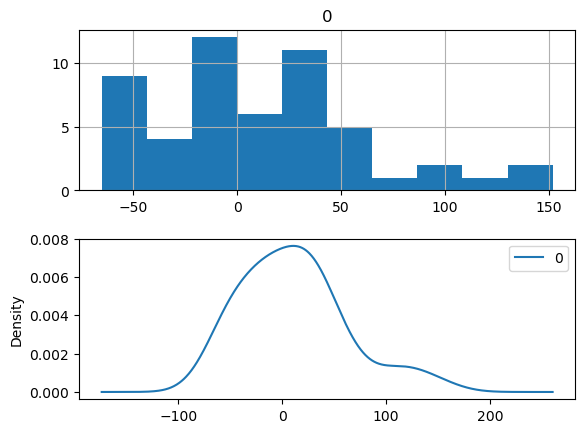

In [18]:
# plot residual errors for ARIMA model

# walk-forward validation
history3 = [x for x in train]
predictions = list()
for i in range(len(test)):
 # predict
 model = ARIMA(history3, order=(0,1,2))
 model_fit = model.fit()
 yhat = model_fit.forecast()[0]
 predictions.append(yhat)
 # observation
 obs = test[i]
 history3.append(obs)
#print(predictions)
#print(history3)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
#print(residuals)
# print(len(residuals))
residuals = DataFrame(residuals)
#print(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
# # q-q plot
# pyplot.subplot(313)
# qqplot(residuals, line='r', ax=pyplot.gca())
pyplot.show()

In [ ]:
# ACF and PACF plots of forecast residual errors
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca(), method="ywm")
pyplot.show()

In [4]:
# invert box-cox transform

def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# walk-forward validation
history4 = [x for x in train]
predictions = list()
#print(predictions)
for i in range(len(test)):
 # transform
 transformed, lam = boxcox(history4)
 if lam < -5:
   transformed, lam = history4, 1
 # predict
 model = ARIMA(transformed, order=(0,1,2))
 model_fit = model.fit()
 yhat = model_fit.forecast()[0]
 # invert transformed prediction
 yhat = boxcox_inverse(yhat, lam)
 predictions.append(yhat)
 # observation
 obs = test[i]
 history4.append(obs)
 print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=99.650, Expected=125.000
>Predicted=115.208, Expected=155.000
>Predicted=136.143, Expected=190.000
>Predicted=165.532, Expected=236.000
>Predicted=206.453, Expected=189.000
>Predicted=180.934, Expected=174.000
>Predicted=178.202, Expected=178.000
>Predicted=179.316, Expected=136.000
>Predicted=145.466, Expected=161.000
>Predicted=165.565, Expected=171.000
>Predicted=166.484, Expected=149.000
>Predicted=152.065, Expected=184.000
>Predicted=179.561, Expected=155.000
>Predicted=155.211, Expected=276.000
>Predicted=238.942, Expected=224.000


/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


>Predicted=210.748, Expected=213.000
>Predicted=214.075, Expected=279.000
>Predicted=257.446, Expected=268.000
>Predicted=255.413, Expected=287.000
>Predicted=275.941, Expected=238.000
>Predicted=245.090, Expected=213.000
>Predicted=226.699, Expected=257.000
>Predicted=252.344, Expected=293.000
>Predicted=275.301, Expected=212.000
>Predicted=224.657, Expected=246.000
>Predicted=248.227, Expected=353.000
>Predicted=313.578, Expected=339.000
>Predicted=312.855, Expected=308.000
>Predicted=305.390, Expected=247.000
>Predicted=263.454, Expected=257.000
>Predicted=268.874, Expected=322.000
>Predicted=307.068, Expected=298.000
>Predicted=290.762, Expected=273.000
>Predicted=279.628, Expected=312.000
>Predicted=305.832, Expected=249.000
>Predicted=259.479, Expected=286.000
>Predicted=288.086, Expected=279.000
>Predicted=277.060, Expected=309.000
>Predicted=300.444, Expected=401.000
>Predicted=361.793, Expected=309.000
>Predicted=307.486, Expected=328.000
>Predicted=330.341, Expected=353.000
>

In [5]:
# invert box-cox transform

def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# walk-forward validation
history4 = [x for x in train]
predictions = list()
#print(predictions)
for i in range(len(test)):
 # transform
 transformed, lam = boxcox(history4)
 if lam < -5:
   transformed, lam = history4, 1
 # predict
 model = ARIMA(transformed, order=(0,1,2))
 model_fit = model.fit()
 yhat = model_fit.forecast()[0]
 # invert transformed prediction
 yhat = boxcox_inverse(yhat, lam)
 predictions.append(yhat)
 # observation
 obs = test[i]
 history4.append(obs)
 print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=99.650, Expected=125.000
>Predicted=115.208, Expected=155.000
>Predicted=136.143, Expected=190.000
>Predicted=165.532, Expected=236.000
>Predicted=206.453, Expected=189.000
>Predicted=180.934, Expected=174.000
>Predicted=178.202, Expected=178.000
>Predicted=179.316, Expected=136.000
>Predicted=145.466, Expected=161.000
>Predicted=165.565, Expected=171.000
>Predicted=166.484, Expected=149.000
>Predicted=152.065, Expected=184.000
>Predicted=179.561, Expected=155.000
>Predicted=155.211, Expected=276.000
>Predicted=238.942, Expected=224.000
>Predicted=210.748, Expected=213.000


/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


>Predicted=214.075, Expected=279.000
>Predicted=257.446, Expected=268.000
>Predicted=255.413, Expected=287.000
>Predicted=275.941, Expected=238.000
>Predicted=245.090, Expected=213.000
>Predicted=226.699, Expected=257.000
>Predicted=252.344, Expected=293.000
>Predicted=275.301, Expected=212.000
>Predicted=224.657, Expected=246.000
>Predicted=248.227, Expected=353.000
>Predicted=313.578, Expected=339.000
>Predicted=312.855, Expected=308.000
>Predicted=305.390, Expected=247.000
>Predicted=263.454, Expected=257.000
>Predicted=268.874, Expected=322.000
>Predicted=307.068, Expected=298.000
>Predicted=290.762, Expected=273.000
>Predicted=279.628, Expected=312.000
>Predicted=305.832, Expected=249.000
>Predicted=259.479, Expected=286.000
>Predicted=288.086, Expected=279.000
>Predicted=277.060, Expected=309.000
>Predicted=300.444, Expected=401.000
>Predicted=361.793, Expected=309.000
>Predicted=307.486, Expected=328.000
>Predicted=330.341, Expected=353.000
>Predicted=342.084, Expected=354.000
>

/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Lambda: 0.259926


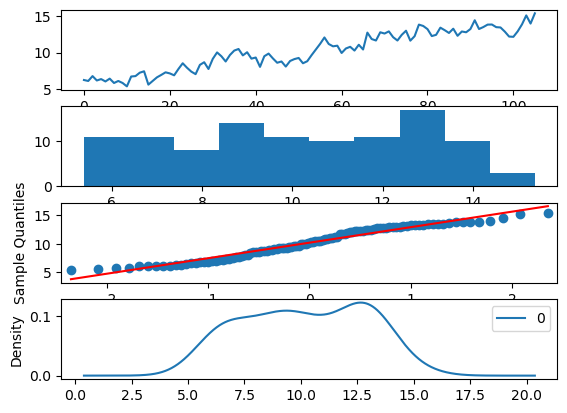

In [6]:
transformed, lam = boxcox(X)
#print(transformed)
print('Lambda: %f' % lam)
pyplot.figure()
# line plot
pyplot.subplot(411)
pyplot.plot(transformed)
# histogram
pyplot.subplot(412)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(413)
qqplot(transformed, line='r', ax=pyplot.gca())
# density plot
pyplot.subplot(414)
transformed=DataFrame(transformed)
transformed.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [7]:
# invert box-cox transform

def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# walk-forward validation
history4 = [x for x in train]
predictions = list()
#print(predictions)
for i in range(len(test)):
 # transform
 transformed, lam = boxcox(history4)
 if lam < -5:
   transformed, lam = history4, 1
 # predict
 model = ARIMA(transformed, order=(0,1,2))
 model_fit = model.fit()
 yhat = model_fit.forecast()[0]
 # invert transformed prediction
 yhat = boxcox_inverse(yhat, lam)
 predictions.append(yhat)
 # observation
 obs = test[i]
 history4.append(obs)
 print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=99.650, Expected=125.000
>Predicted=115.208, Expected=155.000
>Predicted=136.143, Expected=190.000
>Predicted=165.532, Expected=236.000
>Predicted=206.453, Expected=189.000
>Predicted=180.934, Expected=174.000
>Predicted=178.202, Expected=178.000
>Predicted=179.316, Expected=136.000
>Predicted=145.466, Expected=161.000
>Predicted=165.565, Expected=171.000
>Predicted=166.484, Expected=149.000
>Predicted=152.065, Expected=184.000
>Predicted=179.561, Expected=155.000
>Predicted=155.211, Expected=276.000
>Predicted=238.942, Expected=224.000
>Predicted=210.748, Expected=213.000
>Predicted=214.075, Expected=279.000
>Predicted=257.446, Expected=268.000
>Predicted=255.413, Expected=287.000
>Predicted=275.941, Expected=238.000


/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


>Predicted=245.090, Expected=213.000
>Predicted=226.699, Expected=257.000
>Predicted=252.344, Expected=293.000
>Predicted=275.301, Expected=212.000
>Predicted=224.657, Expected=246.000
>Predicted=248.227, Expected=353.000
>Predicted=313.578, Expected=339.000
>Predicted=312.855, Expected=308.000
>Predicted=305.390, Expected=247.000
>Predicted=263.454, Expected=257.000
>Predicted=268.874, Expected=322.000
>Predicted=307.068, Expected=298.000
>Predicted=290.762, Expected=273.000
>Predicted=279.628, Expected=312.000
>Predicted=305.832, Expected=249.000
>Predicted=259.479, Expected=286.000
>Predicted=288.086, Expected=279.000
>Predicted=277.060, Expected=309.000
>Predicted=300.444, Expected=401.000
>Predicted=361.793, Expected=309.000
>Predicted=307.486, Expected=328.000
>Predicted=330.341, Expected=353.000
>Predicted=342.084, Expected=354.000
>Predicted=346.257, Expected=327.000
>Predicted=330.891, Expected=324.000
>Predicted=329.470, Expected=285.000
>Predicted=299.526, Expected=243.000
>

In [8]:
# finalize model and save to file with workaround
# transform data for finalising the model
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit()
# save model
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [9]:
# load the finalized model and make a prediction
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 452.365


>Predicted=452.365, Expected=452.000
>Predicted=429.900, Expected=391.000
>Predicted=401.393, Expected=500.000
>Predicted=476.460, Expected=451.000


/home/mahmud/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


>Predicted=442.453, Expected=375.000
>Predicted=397.527, Expected=372.000
>Predicted=390.647, Expected=302.000
>Predicted=329.393, Expected=316.000
>Predicted=334.171, Expected=398.000
>Predicted=382.819, Expected=394.000
>Predicted=378.508, Expected=431.000
>Predicted=413.525, Expected=431.000
RMSE: 51.949


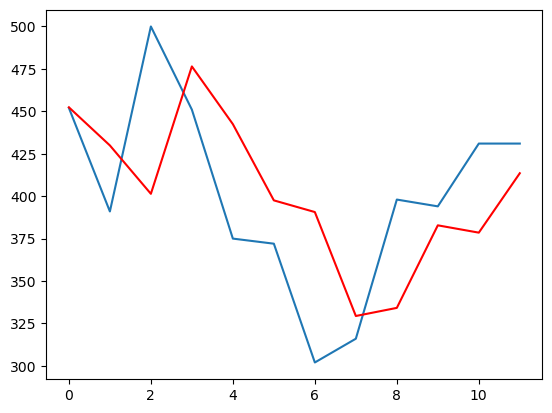

In [12]:
# evaluate the finalized model on the validation dataset
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True).squeeze("columns")
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
 # transform
 transformed, lam = boxcox(history)
 if lam < -5:
   transformed, lam = history, 1
 # predict
 model = ARIMA(transformed, order=(0,1,2))
 model_fit = model.fit()
 yhat = model_fit.forecast()[0]
 # invert transformed prediction
 yhat = boxcox_inverse(yhat, lam)
 predictions.append(yhat)
 # observation
 obs = y[i]
 history.append(obs)
 print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# print(history)
# print(len(history))

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()